# 偏差樣本對模型的影響

用 Google Teachable Machine 訓練兩個不同的樣本，並且使用相同的條件：

```python
Sample num：
    cat: 30
    dog: 30

Batch size: 16
Epoches: 50
Learning rate: 1e-3
```

可以去這裡看看兩個資料集的差別：
```bash
# unbiased dataset (only use #1~30 of dogs and #1~30 of cats)
../train_data

# biased dataset
../biased_train_data
```

最後結果：
```python
Accuracy of biased model:  0.91625
Accuracy of unbiased model:  0.93875
```

註：若要執行該程式，請安裝相關套件
```bash
pip install keras pillow numpy matplotlib seaborn sklearn
```

In [72]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

In [73]:
def myPreproc(testdata_path):

    all_img = os.listdir(testdata_path)
    all_img_label = [i.split(".")[0] for i in all_img]
    N = len(all_img)
    data = np.ndarray(shape=(N, 224, 224, 3), dtype=np.float32)

    for i in range(N):
        
        img_path = testdata_path + all_img[i]
        label = all_img[i].split(".")[0]
        image = Image.open(img_path).convert("RGB")
        size = (224, 224)
        image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
        image_array = np.asarray(image)
        normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
        data[i,:,:,:] = normalized_image_array

    return data, all_img_label, all_img

In [74]:
def myPredict(model, data, class_names, batch_size=1, verbose=1):
    N = data.shape[0]
    prediction = np.array(model.predict(data, batch_size=batch_size, verbose=verbose))
    index = prediction.argmax(axis=1)
    Y_test=[]
    confidence_score = []
    for i in range(N):
        Y_test.append(class_names[index[i]].split(" ")[1])
        confidence_score.append(prediction[i][index[i]])

    return (Y_test, confidence_score)

In [75]:
def myEval(y_test, all_img_label, all_img, plot_cm=True, title="Confusion Matrix"):
    
    y_test_label, conf = y_test
    N = len(y_test_label)
    wrong_pred = []
    correct = 0
    for i in range(N):
        if y_test_label[i] == all_img_label[i]:
            correct += 1
        else:
            wrong_pred.append(i)
    # print("Accuracy: ", correct/N)

    lables_name = ["cat", "dog"]
    cm = confusion_matrix(all_img_label, y_test_label, labels=lables_name)

    # plot confusion matrix
    if plot_cm:
        
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        # set axis to label name
        tick_marks = np.arange(len(lables_name)) + 0.5
        plt.xticks(tick_marks, lables_name)
        plt.yticks(tick_marks, lables_name)
        plt.show()
    
    return (correct/N), wrong_pred

180/180 [==============================] - 3s 13ms/step


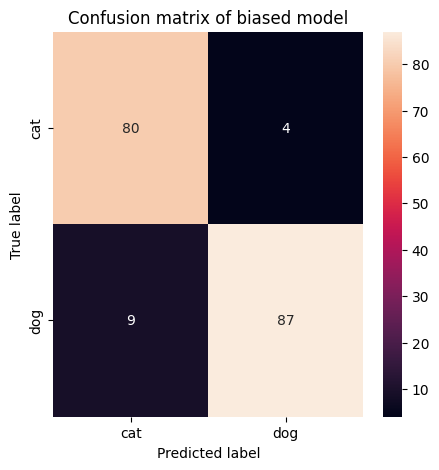

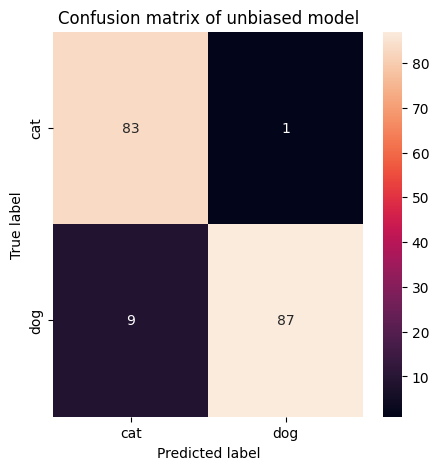

Accuracy of biased model:  0.9277777777777778
Accuracy of unbiased model:  0.9444444444444444


In [76]:
# Load the model
model_b = load_model("./model_biased/biased_model.h5", compile=False)
model = load_model("./model/model.h5", compile=False)

# Load the labels
class_names = open("./model_biased/labels.txt", "r").readlines()
class_names = [c.strip() for c in class_names]

# test data path
testdata_path = "../test_data/"
#testdata_path = "../test_data_big/"

# Preprocess the test data
data, all_img_label, all_img = myPreproc(testdata_path)

# Predict the test data
Y_test_b = myPredict(model_b, data, class_names)
Y_test = myPredict(model, data, class_names)

# Evaluate the model
acc_b, wrong_pred_b = myEval(Y_test_b, all_img_label, all_img, plot_cm=True, title="Confusion matrix of biased model")
acc, wrong_pred = myEval(Y_test, all_img_label, all_img, plot_cm=True, title="Confusion matrix of unbiased model")

print("Accuracy of biased model: ", acc_b)
print("Accuracy of unbiased model: ", acc)


# 找出辨識錯誤照片

印出兩個模型看錯的照片，可以試著分析其差異

biased model


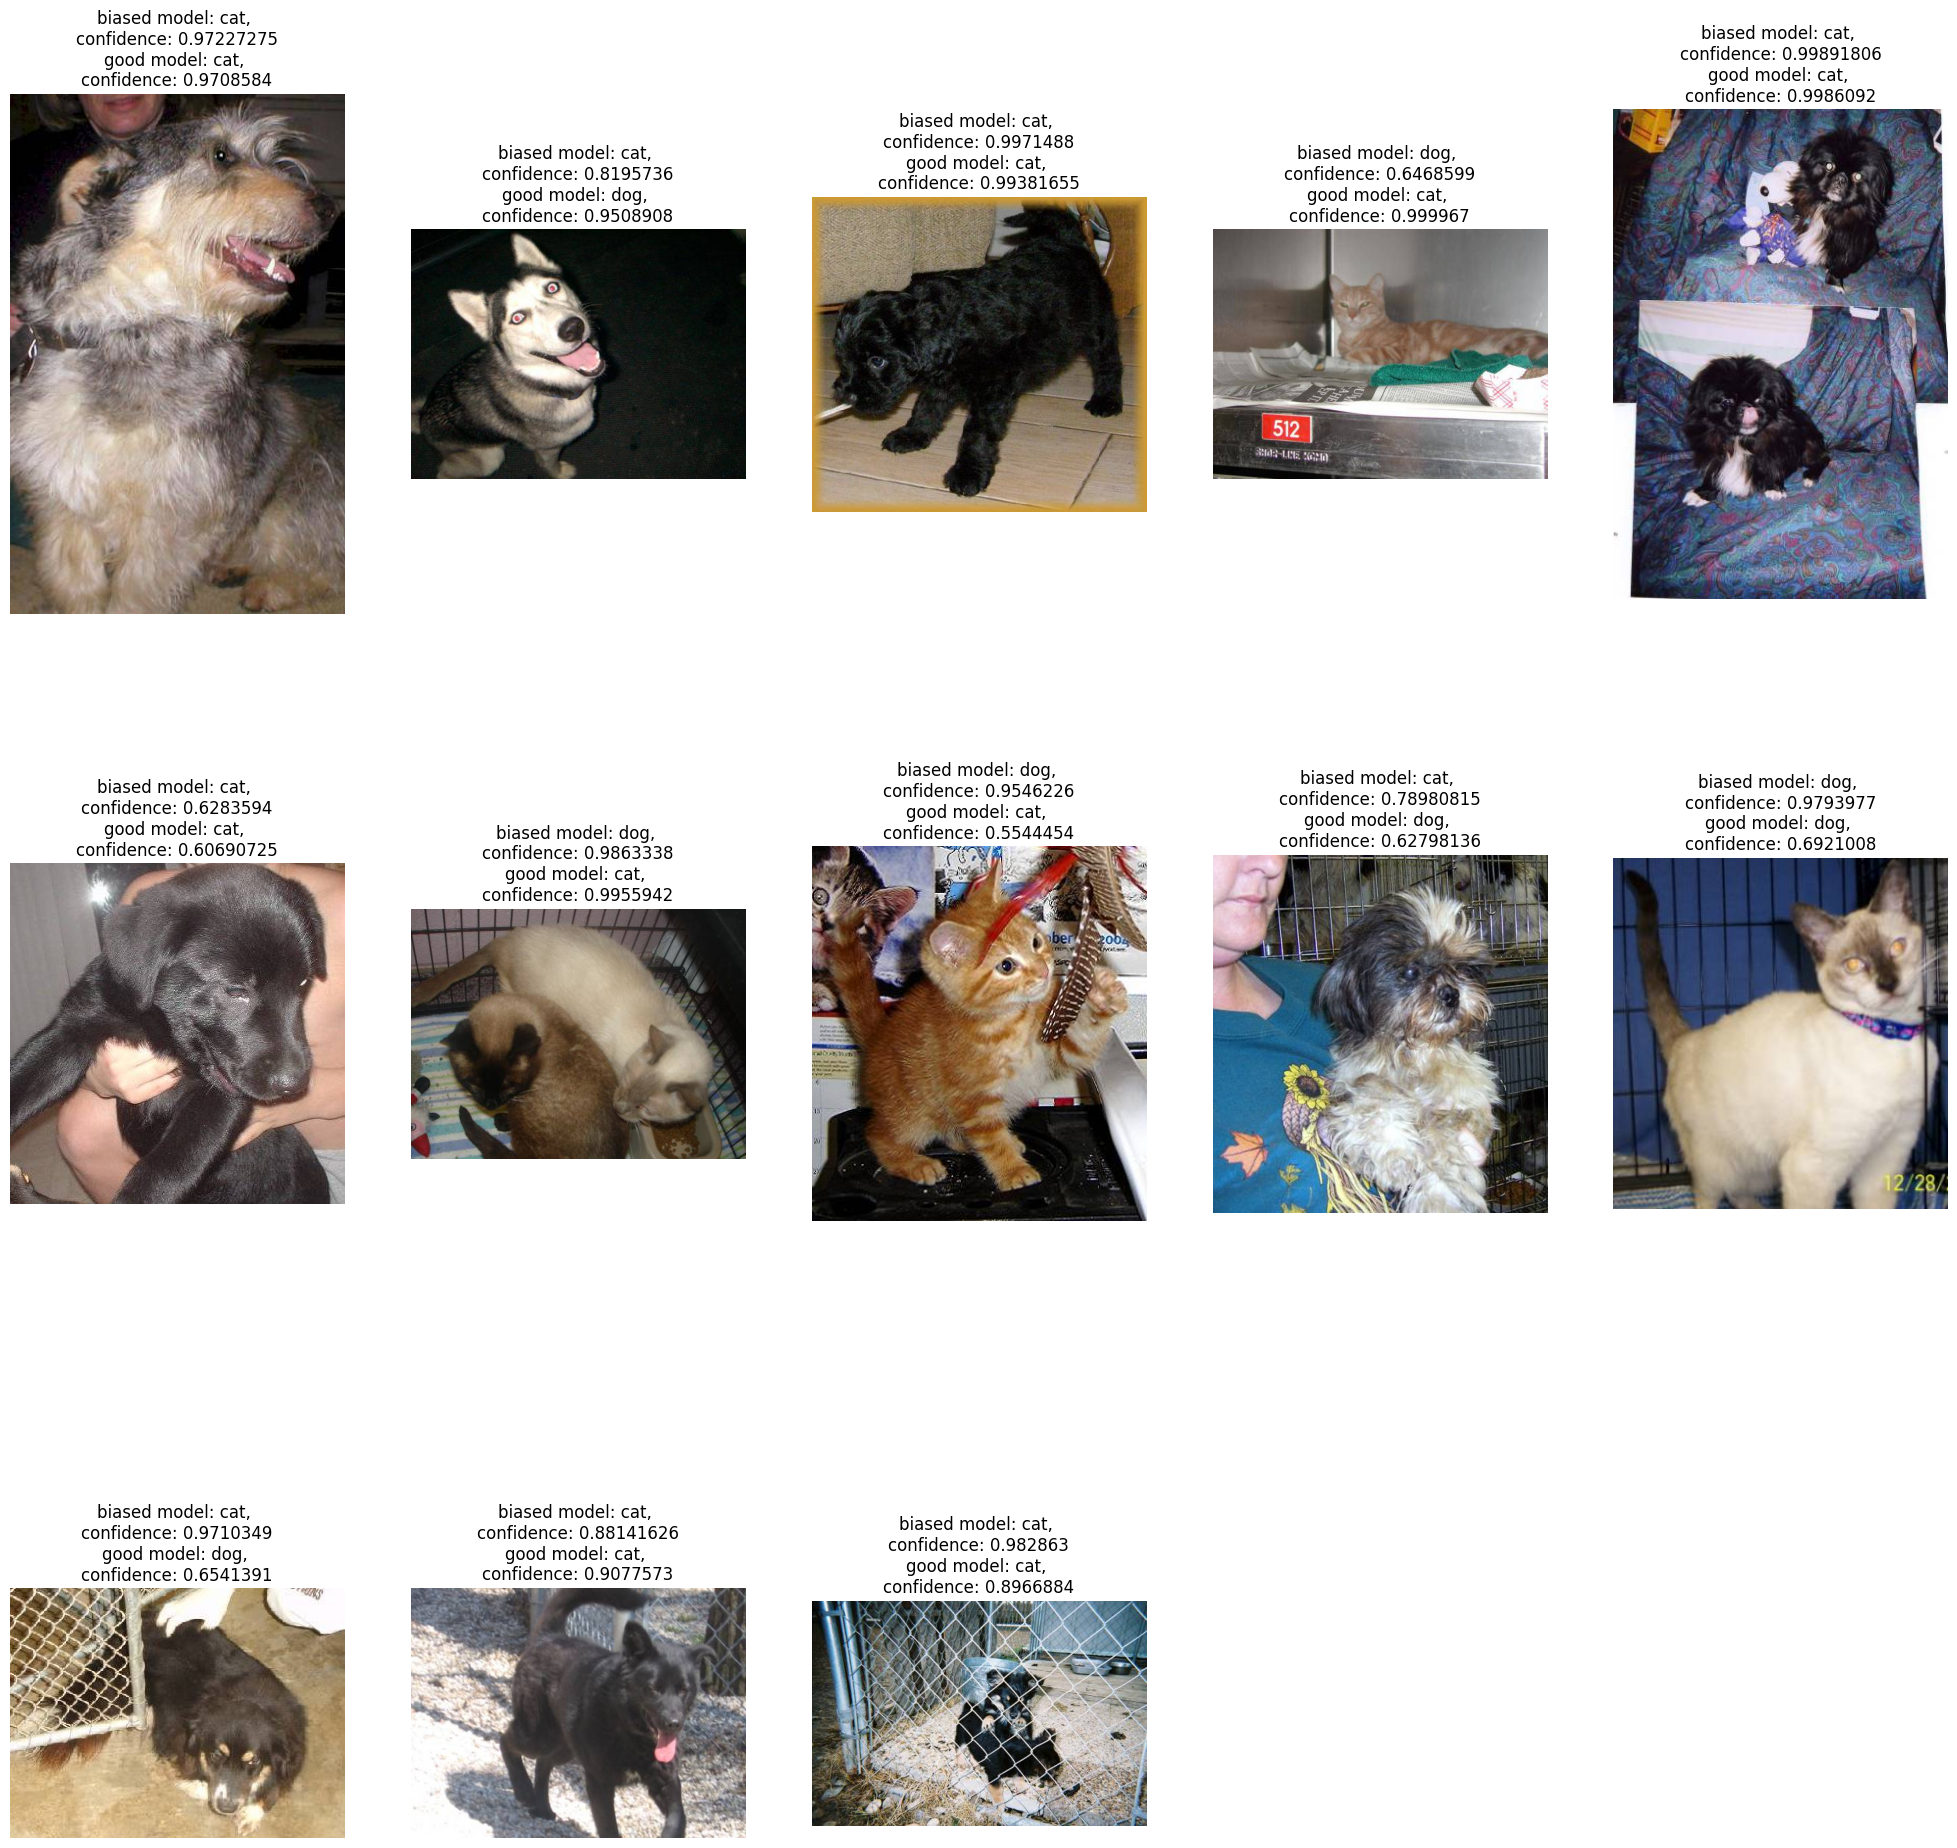

unbiased model


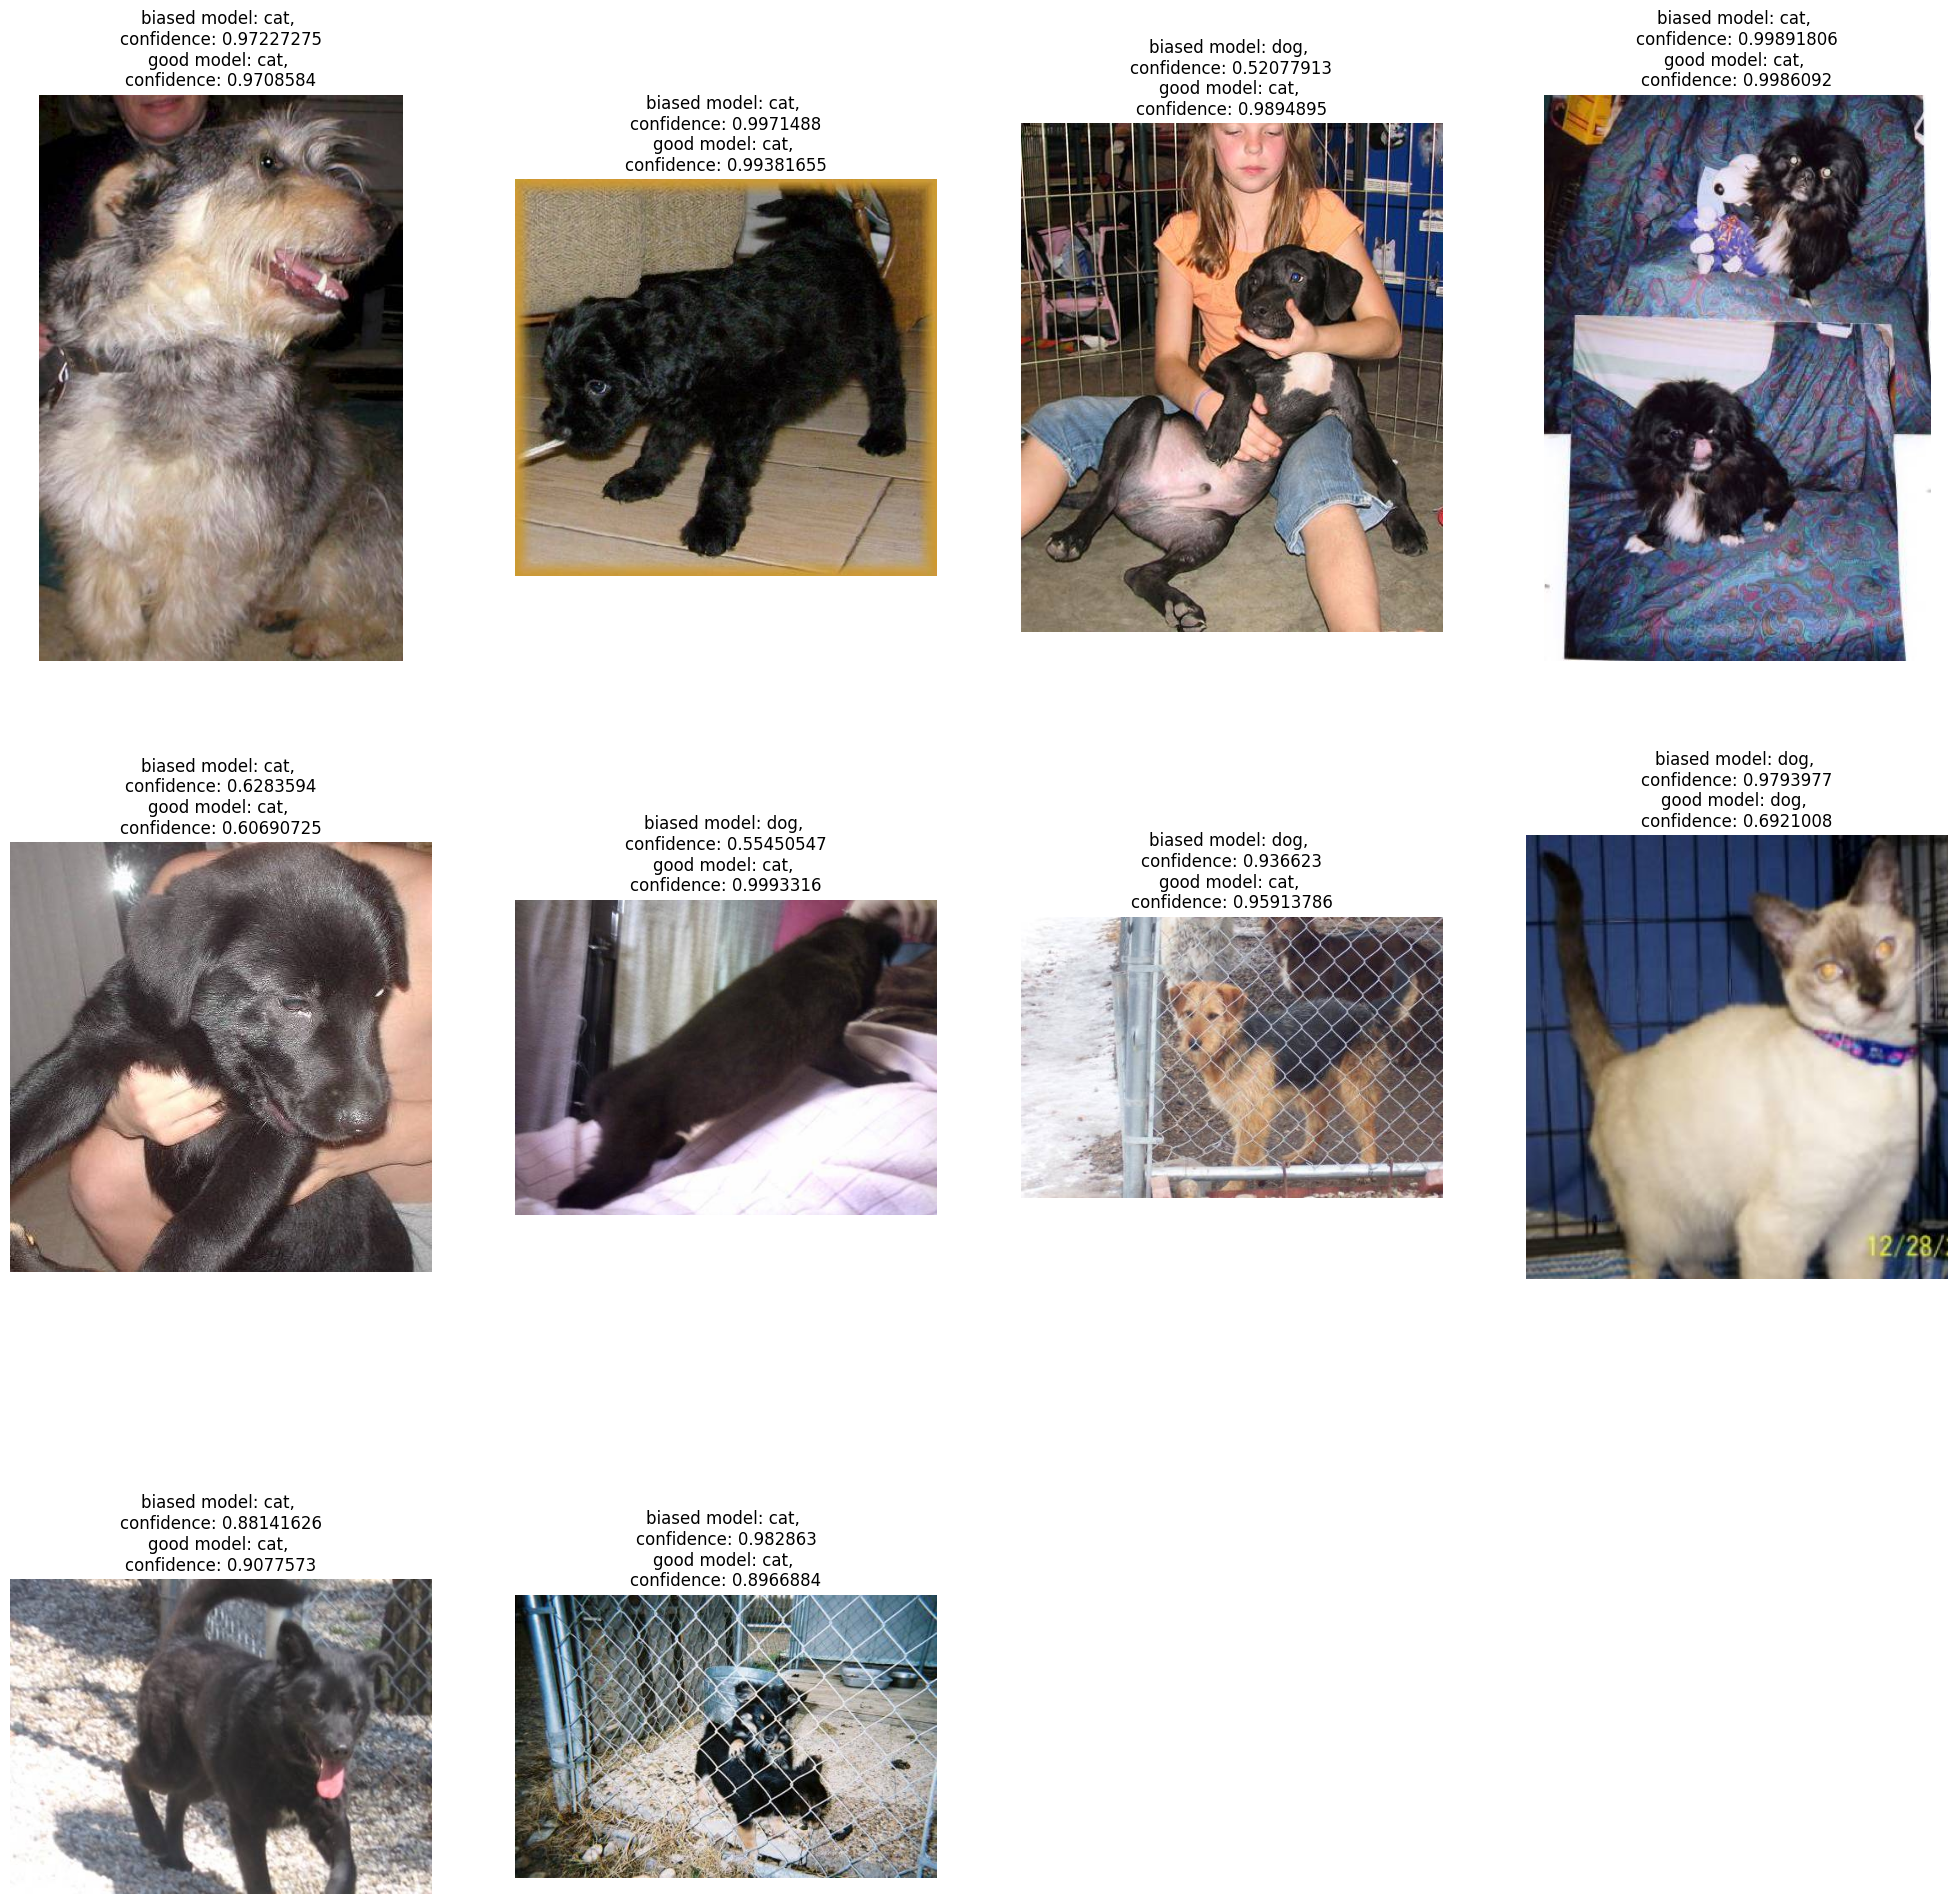

wrong in biased model but correct in unbiased model


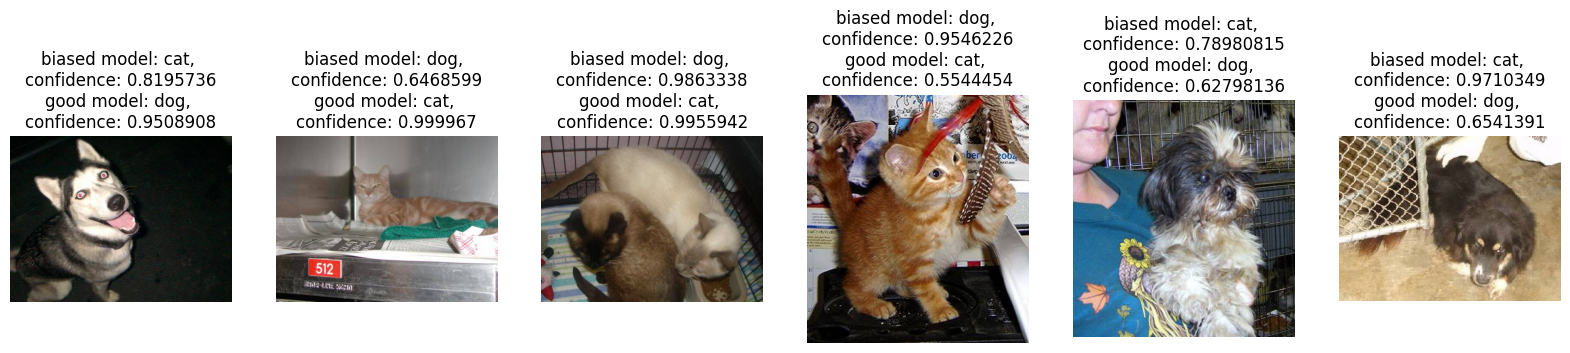

wrong in unbiased model but correct in biased model


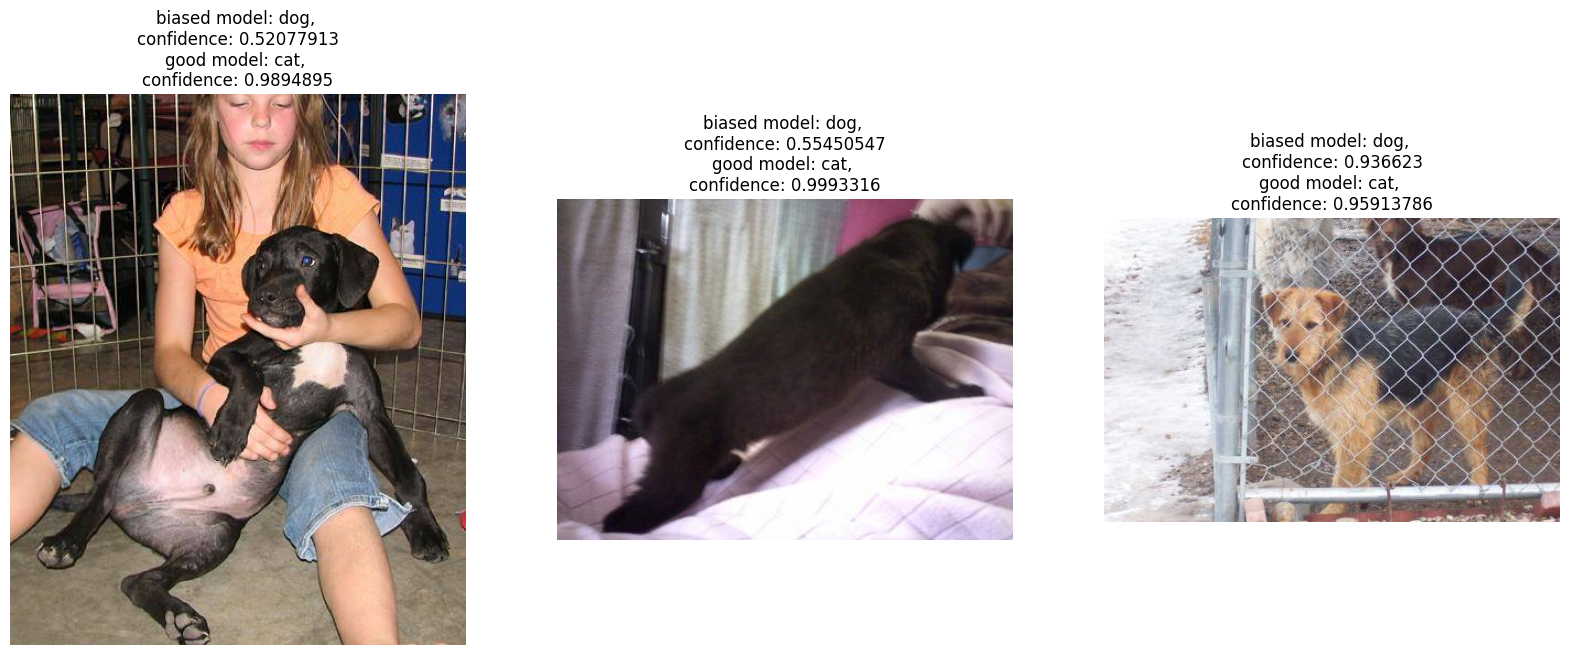

In [87]:
# plot the wrong prediction images

plt.figure(figsize=(25,25))

pred_b, conf_b = Y_test_b
pred, conf = Y_test

# Plot the wrong prediction images of biased model
for i in range(len(wrong_pred_b)):
    index = wrong_pred_b[i]
    img_path = testdata_path + all_img[index]
    image = Image.open(img_path).convert("RGB")
    plt.subplot(3, len(wrong_pred_b) // 3 + 1, i+1)
    plt.imshow(image)
    title_str = "biased model: " + pred_b[index] + ", \nconfidence: " + str(conf_b[index])
    title_str += "\ngood model: " + pred[index] + ", \nconfidence: " + str(conf[index])
    plt.title(title_str)
    plt.axis("off")

print("biased model")
plt.show()

# Plot the wrong prediction images of unbiased model
plt.figure(figsize=(25,25))
for i in range(len(wrong_pred)):
    index = wrong_pred[i]
    img_path = testdata_path + all_img[index]
    image = Image.open(img_path).convert("RGB")
    plt.subplot(3, len(wrong_pred) // 3 + 1, i+1)
    plt.imshow(image)
    title_str = "biased model: " + pred_b[index] + ", \nconfidence: " + str(conf_b[index])
    title_str += "\ngood model: " + pred[index] + ", \nconfidence: " + str(conf[index])
    plt.title(title_str)
    plt.axis("off")

print("unbiased model")
plt.show()


diff_d = []
for i in range(len(wrong_pred_b)):
    index = wrong_pred_b[i]
    if wrong_pred_b[i] not in wrong_pred:
        diff_d.append(index)

plt.figure(figsize=(20,20))
for i in range(len(diff_d)):
    index = diff_d[i]
    img_path = testdata_path + all_img[index]
    image = Image.open(img_path).convert("RGB")
    plt.subplot(1, len(diff_d), i+1)
    plt.imshow(image)
    title_str = "biased model: " + pred_b[index] + ", \nconfidence: " + str(conf_b[index])
    title_str += "\ngood model: " + pred[index] + ", \nconfidence: " + str(conf[index])
    plt.title(title_str)
    plt.axis("off")

print("wrong in biased model but correct in unbiased model")
plt.show()


diff = []
for i in range(len(wrong_pred)):
    index = wrong_pred[i]
    if wrong_pred[i] not in wrong_pred_b:
        diff.append(index)

plt.figure(figsize=(20,20))
for i in range(len(diff)):
    index = diff[i]
    img_path = testdata_path + all_img[index]
    image = Image.open(img_path).convert("RGB")
    plt.subplot(1, len(diff), i+1)
    plt.imshow(image)
    title_str = "biased model: " + pred_b[index] + ", \nconfidence: " + str(conf_b[index])
    title_str += "\ngood model: " + pred[index] + ", \nconfidence: " + str(conf[index])
    plt.title(title_str)
    plt.axis("off")

print("wrong in unbiased model but correct in biased model")
plt.show()

